In [23]:
import json
import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib import colors

In [83]:
min_date = "2023_11_27"
folder = "/mnt/share/lcncluster/bellec/multi-task/results"
imbalanced = True
ignore_terms = ["project2", "project-", "project1"]

results = []
names = []
for result_file in os.listdir(folder):
    if result_file > min_date:
        if (imbalanced and "imbalance" in result_file) or (not imbalanced and not "imbalance" in result_file):
            with open(os.path.join(folder, result_file), "r") as f:
                name = result_file.split("_")[-1][:-5]
                if "imbalance" in name: name = name[:-11]

                if all([not t in name for t in ignore_terms]):
                        results += [json.load(f)]
                        names += [name]
names

['single-task',
 'single-task',
 'single-task',
 'summed-loss',
 'summed-loss',
 'summed-loss',
 'normalized-splitter',
 'normalized-splitter',
 'normalized-splitter',
 'pcgrad',
 'pcgrad',
 'pcgrad',
 'normalized-project3-splitter',
 'normalized-project3-splitter',
 'project3-splitter',
 'project3-splitter',
 'project3-splitter',
 'normalized-project3-splitter']

In [84]:
def smooth_curve(values, mom=0.8):
    new_values = []
    last_v = None
    for v in values:
        v = v if last_v is None else last_v * mom + (1-mom) * v
        last_v = v
        new_values += [v]
    return new_values


def get_results(name, key):
    res_selection = []
    for n, r in zip(names, results):
        if n == name:
            res_selection += [r[key]]

    res_selection = [smooth_curve(res) for res in res_selection]
    res_selection = np.stack(res_selection, 0)

    return res_selection.mean(0), res_selection.std(0)

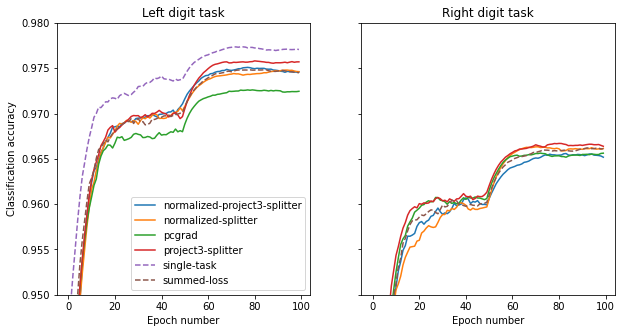

In [85]:
keys = ["test_acc_L", "test_acc_R"] #, "train_loss_L", "train_loss_R"]
color_list = list(colors.TABLEAU_COLORS.keys())
color_list = color_list + color_list + color_list
fig, ax_list = plt.subplots(1,len(keys), sharey="all", sharex="all", figsize=(len(keys)*5, 5))

unique_names = np.sort(np.unique(names))

for k, name in enumerate(unique_names):
    for i, key in enumerate(keys):

        m, s = get_results(name, key)
        line = np.arange(len(m))
        linestyle = "dashed" if name in ["single-task","summed-loss"] else "solid"
        ax_list[i].plot(line,m, color=color_list[k], label=name, linestyle=linestyle)
        #ax_list[i].fill_between(line, m-s, m+s, color=color_list[k], alpha=0.01)


for i, key in enumerate(keys):
    if not imbalanced:
        if "acc" in key:
            ax_list[i].set_ylim([0.95,0.98])
        if "loss" in key:
            ax_list[i].set_ylim([0.,0.2])
    else:
        if "acc" in key:
            ax_list[i].set_ylim([0.90,0.98])
        if "loss" in key:
            ax_list[i].set_ylim([0.,0.2])

ax_list[0].set_ylabel("Classification accuracy")
for i in range(len(ax_list)):
    ax_list[i].set_xlabel("Epoch number")

ax_list[0].set_title("Left digit task" if not imbalanced else "Right digit (loss scale x1)")  
ax_list[1].set_title("Right digit task" if not imbalanced else "Right digit (loss scale x1000)")    

ax_list[0].legend()
if imbalanced:
    fig.savefig("figures/summary_imbalanced.png")
else:
    fig.savefig("figures/summary.png")